### Test the raster image dataloader

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader 
import numpy as np
import raster_relight as rr
import raster_dataloader as rd
import open3d as o3d
import open3d.core as o3c
from matplotlib import pyplot as plt

from model import LightMLP

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/dtetruash/.miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/dtetruash/.miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
ds = rd.OLATDataset(split='val')

Loading dataset from chair_intrinsic/val: 100%|█| 140/140 [00:08<00:00, 16.80it/s]


In [3]:
image_number = 3
light_name = 'arealightfront'

In [4]:
W, H, raster_image_pixels, world_normals, albedo, posed_points, _, occupancy_mask = ds.attributes[image_number][light_name]


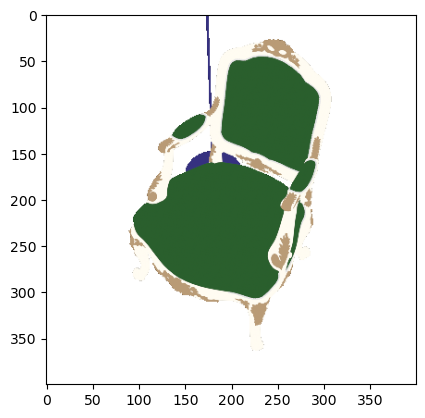

In [5]:
#%%script echo skipping
albedo_img = np.ones((W,H,3))
albedo_img[occupancy_mask] = albedo
plt.imshow(albedo_img)

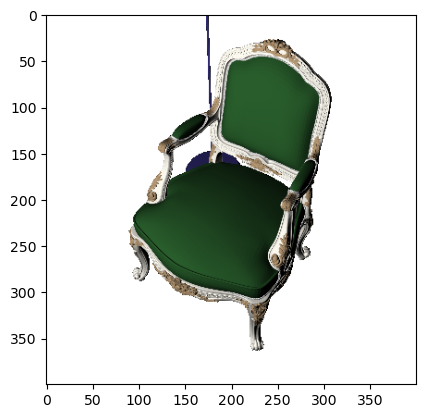

In [6]:
#%%script echo skipping
raster_img = np.ones((W,H,3))
raster_img[occupancy_mask] = raster_image_pixels
plt.imshow(raster_img)

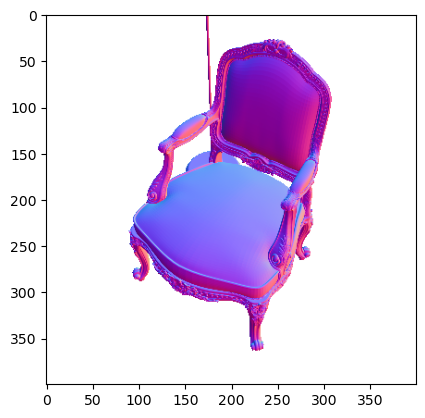

In [7]:
#%%script echo skipping
normal_img = np.ones((W,H,3)) 
normal_img[occupancy_mask] = world_normals * 0.5 + 0.5
plt.imshow(normal_img)

### Make sure the normals and light vectors are well aligned

In [8]:
# map_to_tensors = {}
# map_to_tensors["positions"] = posed_points, 
#map_to_tensors["colors"] = raster_image_pixels, 
#map_to_tensors["normals"] = world_normals, 


pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(posed_points))
pcd.normals = o3d.utility.Vector3dVector(world_normals)
pcd.colors = o3d.utility.Vector3dVector(raster_image_pixels)


In [9]:
o3d.visualization.draw_geometries([pcd])

In [ ]:
downpcd = pcd.voxel_down_sample(voxel_size=0.2)

In [ ]:
o3d.visualization.draw_geometries([downpcd])

In [ ]:
# make line set to the light point.

In [ ]:
downpcd_points = np.asarray(downpcd.points)
len(downpcd_points)

In [ ]:
pcd_points = np.asarray(pcd.points)
pcd_points.shape

In [ ]:
step = 20

In [ ]:
# Create the model
checkpoint = torch.load('/home/dtetruash/Thesis/intrinsic-light-estimation/light_mlp/model_trained/light-mlp-supervised-cosine_breezy-plasma-48.pth')
mlp = LightMLP(3, [256]*4 + [128]) # TODO: Change to dict values later
mlp.load_state_dict(checkpoint)

In [ ]:
with torch.inference_mode():
    # prepare inputs for inference
    feats = np.stack([world_normals, albedo, raster_image_pixels], axis=1)
    inputs = torch.flatten(torch.as_tensor(feats).float(), start_dim=1)

    # Do inference to get light vectors
    light_vectors = mlp(inputs)
    light_vectors = light_vectors.numpy().astype(np.float32)

num_vecs = light_vectors.shape[0]
light_vectors.shape

In [ ]:
ls_points_light = np.array([(i ,i + l*n) for (i,l,n) in zip(pcd_points, light_vectors, np.array([3.0] * num_vecs))][::step]).reshape(-1,3)
ls_points_light.shape

In [ ]:
ls_edges_light = [(i, i+1) for i in range(0,len(ls_points_light),2) ][::step]
len(ls_edges_light)

In [ ]:

line_set_light = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(ls_points_light),
    lines=o3d.utility.Vector2iVector(ls_edges_light),
)
line_set_light.colors = o3d.utility.Vector3dVector([(1,0,0)]*len(ls_edges_light))

In [ ]:
# ls_points_cam = np.array([(i ,i + l*n) for (i,l,n) in zip(pcd_points, ds._cam_vecs, ds._cam_vec_norms)][::step]).reshape(-1,3)
# ls_points_cam.shape


In [ ]:
# ls_edges_cam = [(i, i+1) for i in range(0,len(ls_points_cam),2) ][::step]
# len(ls_edges_cam)

In [ ]:

# line_set_cam = o3d.geometry.LineSet(
#     points=o3d.utility.Vector3dVector(ls_points_cam),
#     lines=o3d.utility.Vector2iVector(ls_edges_cam),
# )
# line_set_cam.colors = o3d.utility.Vector3dVector([(0,1,0)]*len(ls_edges_cam))

In [ ]:
mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0, resolution=10)
mesh_sphere.compute_vertex_normals()
mesh_sphere.paint_uniform_color([0.1, 0.1, 0.7])

In [ ]:
sphere_line_set = o3d.geometry.LineSet.create_from_triangle_mesh(mesh_sphere)


In [ ]:
sphere_line_set.colors = o3d.utility.Vector3dVector(np.array([[0,0,0]]*len(sphere_line_set.lines)))

In [ ]:
# light point 
light_loc = [-0.5555621981620789, -2.452761173248291, 1.7225751876831055]
light_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.05)
light_sphere.compute_vertex_normals()
light_sphere.paint_uniform_color([0.5,0.5,0])
light_sphere.translate(light_loc)

In [ ]:
# cam_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.05)
# cam_sphere.compute_vertex_normals()
# cam_sphere.paint_uniform_color([0.1,0.8,0.1])
# cam_sphere.translate(ds._camera_center)

In [ ]:
axis_set =  o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[v*(a:=10),-v*a] for v in np.eye(3)]).reshape(-1,3)),
    lines=o3d.utility.Vector2iVector([(i, i+1) for i in range(0,6,2) ]),
)
axis_set.colors = o3d.utility.Vector3dVector(np.eye(3))

In [ ]:
o3d.visualization.draw_geometries([downpcd, line_set_light, light_sphere, axis_set])

In [ ]:
list(range(8))[::4]

In [ ]:
# make sphere point clou[d
basis = np.array([[0]*3]*3)
for i,b in enumerate(basis):
    b[i] +=1
basis

## Doing the same with the model vectors


In [ ]:
# load model
model = 